In [1]:
import xarray as xr
import rioxarray as rxr
import rasterio as rio
import cartopy.crs as ccrs
import cartopy
import numpy as np
import matplotlib.pyplot as plt
import fiona
import pyproj

import fiona
import geopandas as gpd
from shapely.geometry import mapping


import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (20, 20)

In [5]:
urlpath_prev =f"https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/dlwrf.{2021}.nc"
urlpath_current =f"https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/dlwrf.{2021}.nc"
ds_previous = xr.open_dataset(urlpath_prev,decode_coords="all")
ds_current = xr.open_dataset(urlpath_current,decode_coords="all")



ds_current

<xarray.Dataset>
Dimensions:            (time: 365, y: 277, x: 349, nbnds: 2)
Coordinates:
  * time               (time) datetime64[ns] 2021-01-01 ... 2021-12-31
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    Lambert_Conformal  int32 ...
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
Dimensions without coordinates: nbnds
Data variables:
    time_bnds          (time, nbnds) float64 ...
    dlwrf              (time, y, x) float32 ...
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    ...                              ...
    history:                         created Sat Mar 26 05:01:06 MDT 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    References:                      
    DODS_EXTRA.Unlimited_Dimension:  time

In [4]:
def trim_ds(ds, centroid):
    # Locate the centroid
    loc_lat = centroid[0]
    loc_lon = centroid[1]
    # Get centroid lat and lon values
    lat = ds.lat.values
    lon = ds.lon.values
    # Take the absolute value of these measurements
    abs_lon = np.abs(lon - loc_lon)
    abs_lat = np.abs(lat - loc_lat)
    # Locate the maximum values of the difference
    maxi = np.maximum(abs_lon,abs_lat)
    # Find the index of the minimum to get the closest cells
    loc_index = np.argmin(maxi)
    # Unravel the index and locate the x and y indeces where the cells of interest are
    ij = np.unravel_index(loc_index,(ds.dims['y'],ds.dims['x']))
    i_loc_index=ij[0]
    j_loc_index=ij[1]
    # Isolate these cells
    ds_local = ds.isel(y=slice(i_loc_index-1,i_loc_index+2),x=slice(j_loc_index-1,j_loc_index+1)).drop_dims('nbnds')
    return ds_local

def get_narr_data(year, product, centroid):
    """Grads NARR product and filters to 12 grid cells around centroid

    Args:
        year (int): year
        product (str): product value to pull from NARR
        centroid (tuple): tuple or list of centroid locations to filter on

    Returns:
        dataset
    """
    # URL path to thredds server for NARR data
    urlpath =f"https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/{product}.{year}.nc"
    # Check if product is accumulated precipitation
    if product == 'apcp':
        # If true, get the current year and year prior data
        urlpath_prev =f"https://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/NARR/Dailies/monolevel/{product}.{year-1}.nc"
        ds_previous = xr.open_dataset(urlpath_prev,decode_coords="all")
        ds_current = xr.open_dataset(urlpath,decode_coords="all")

        # Concatenate each and create dataset spanning water year
        ds = xr.concat([trim_ds(ds_previous,(38,-107)),trim_ds(ds_current,(38,-107))],dim='time')
        ds_wy = ds.sel(time=slice(f'{year-1}-10-1',f'{year}-9-30'))
        
        # Compute annual precip by dividing by number of cells
        annual_precip = (ds_wy.apcp.sum()/(ds_wy.apcp.shape[1]*ds_wy.apcp.shape[2])) # kg/m2 * km2 / 1000**2 m2/km2 / 1 m3/1000 kg
        return ds_wy, annual_precip.values
    else:
        # Otherwise, grab the data and filter it
        ds = xr.open_dataset(urlpath,decode_coords="all")
        ds_local = trim_ds(ds,(38,-107))
        return ds_local



In [8]:
# get all NARR precip data
import fiona
fiona.drvsupport.supported_drivers['KML'] = 'rw'
east_river_polygon = gpd.read_file("./data/polygons/East_River.kml", driver='KML')
products = ['apcp', 'dlwrf', 'ulwrf.sfc', 'dswrf', 'uswrf.sfc']
centroid = east_river_polygon.centroid
years = np.arange(1980,2022,1)

In [64]:
# Initialize a list to fill with data
narr_precip_totals = []
narr_precip_data = []
# Iterate over each year
for year in years:
    # Print every decade
    if year % 10 == 0:
        print(f'Working in the {year}s')
    # Get dataset for each year and annual precip values
    ds,annual_precip = get_narr_data(year,products[0],(centroid.y.values, centroid.x.values))
    # Add annual precip value to list for eventual comparison
    narr_precip_totals.append(annual_precip)
    narr_precip_data.append(ds)


Working in the 1980s
Working in the 1990s
Working in the 2000s
Working in the 2010s
Working in the 2020s


In [67]:
precip = xr.concat(narr_precip_data, dim='time')
precip.apcp.encoding={}
precip.to_netcdf('./data/met/NARR_apcp_1980_2022.nc')

In [31]:
# Initialize dictionary to fill with datasets for each product
data_sets={}
# Iterate over products not including apcp
for product in products[1:]:
    print(f'Grabbing {product}')
    # Create an empty list to fill with datasets
    data_sets[product] = []
    # Iterate over years to grab the correct data
    for i,year in enumerate(years):
        # Print each decade
        if year % 10 == 0:
            print(f'Working in the {year}s')
        # Get dataset for product and year and only get specific values
        ds = get_narr_data(year, product,(centroid.y.values, centroid.x.values))
        # Append this dataset to the list within the dictionary for each product
        data_sets[product].append(ds)

Grabbing dlwrf
Working in the 1980s
Working in the 1990s
Working in the 2000s
Working in the 2010s
Working in the 2020s
Grabbing ulwrf.sfc
Working in the 1980s
Working in the 1990s
Working in the 2000s
Working in the 2010s
Working in the 2020s
Grabbing dswrf
Working in the 1980s
Working in the 1990s
Working in the 2000s
Working in the 2010s
Working in the 2020s
Grabbing uswrf.sfc
Working in the 1980s
Working in the 1990s
Working in the 2000s
Working in the 2010s
Working in the 2020s


In [36]:
lw_d = xr.concat(data_sets['dlwrf'],dim='time')
lw_u = xr.concat(data_sets['ulwrf.sfc'],dim='time')
sw_d = xr.concat(data_sets['dswrf'],dim='time')
sw_u = xr.concat(data_sets['uswrf.sfc'],dim='time')

In [60]:
rnet_ds = xr.merge([lw_d,lw_u,sw_d,sw_u])
rnet_ds.dlwrf.encoding = {}
rnet_ds.ulwrf.encoding = {}
rnet_ds.dswrf.encoding = {}
rnet_ds.uswrf.encoding = {}
rnet_ds.to_netcdf('./data/NARR_rnet_1980_2022.nc')

In [18]:
import pandas as pd
precip_df=pd.Series(narr_precip_totals, index=years,name='narr_precip_totals_mm')
precip_df.to_csv('./data/narr_precip_1980_2022.csv')

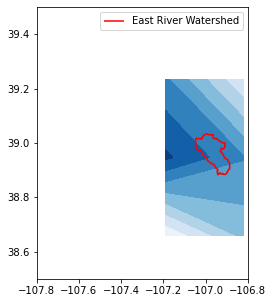

In [32]:
# Visualize one day of data
fig, ax=plt.subplots(figsize=(10,5))
ds_1day = ds.sel(time='2021-12-23')
ax.contourf(ds_1day.lon.values, ds_1day.lat.values, ds_1day.apcp.values, zorder=2, cmap='Blues')
east_river_polygon.boundary.plot(ax=ax, label='East River Watershed', color='red',zorder=10)

#Zoom in
extent=[-107.8,-106.8,38.5,39.5]

ax.set_xlim(*extent[0:2])
ax.set_ylim(*extent[2:])
ax.legend()

In [11]:
def plotMap():
    # adapted from https://www.guillaumedueymes.com/post/narr_synoptic/
    #Set the projection information
    proj = ccrs.LambertConformal(central_longitude=-107.0,central_latitude=50, standard_parallels=[50])
    #Create a figure with an axes object on which we will plot. Pass the projection to that axes.
    fig, ax = plt.subplots(subplot_kw=dict(projection=proj))
    
    #Zoom in
    ax.set_extent([-130,-70,20,60]);
    
    #Add map features
    ax.add_feature(cartopy.feature.LAND, facecolor='0.9'); #Grayscale colors can be set using 0 (black) to 1 (white)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.9);  #Alpha sets transparency (0 is transparent, 1 is solid)
    ax.add_feature(cartopy.feature.BORDERS, zorder=10);
    ax.add_feature(cartopy.feature.COASTLINE, zorder=10);
    ax.add_feature(cartopy.feature.LAKES, zorder=10);


    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cartopy.feature.NaturalEarthFeature(
            category='cultural',  name='admin_1_states_provinces_lines',
            scale='50m', facecolor='none');
    ax.add_feature(states_provinces, edgecolor='gray', zorder=10);
    
    #Add lat/lon gridlines every 20° to the map
    ax.gridlines(xlocs=np.arange(0,361,20), ylocs=np.arange(-80,90,20));
    
    return fig, ax